In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack 
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
selected_ev            = 2        # which Eigenvector to choose
ϵ                      = 0.2      # perturbation
t₀                      = 0.6;    # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-5
solver                 = OrdinaryDiffEq.Tsit5();

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end];

In [5]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [6]:
M = assembleMassMatrix(ctx);

In [7]:
# assemble K
DT₀(x) = linearized_transfer_function_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀);

 18.651005 seconds (68.27 M allocations: 3.805 GiB, 5.23% gc time)


In [8]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
if u₀[Int(floor(0.5*grid_resolution*grid_resolution+0.25*grid_resolution))]>0
    u₀ = -u₀                    # eigs is nondeterministic with respect to the sign, so normalize
end
λ₀

  3.163824 seconds (9.52 M allocations: 555.043 MiB, 5.12% gc time)


-53.85535425626238

In [9]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor_autodiff(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot);

 34.175692 seconds (54.45 M allocations: 3.925 GiB, 2.81% gc time)


In [14]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.659037 seconds (2.37 M allocations: 133.687 MiB, 3.50% gc time)


-69.88802942543055

In [15]:
# calculate the exact uϵ
DTϵ(x) = linearized_transfer_function_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
if uϵ[Int(floor(0.5*grid_resolution*grid_resolution+0.25*grid_resolution))]>0
    uϵ = -uϵ
end
λϵ

-70.63565016836374

In [16]:
λ₀ + ϵ*λ_dot

-67.8329601413485

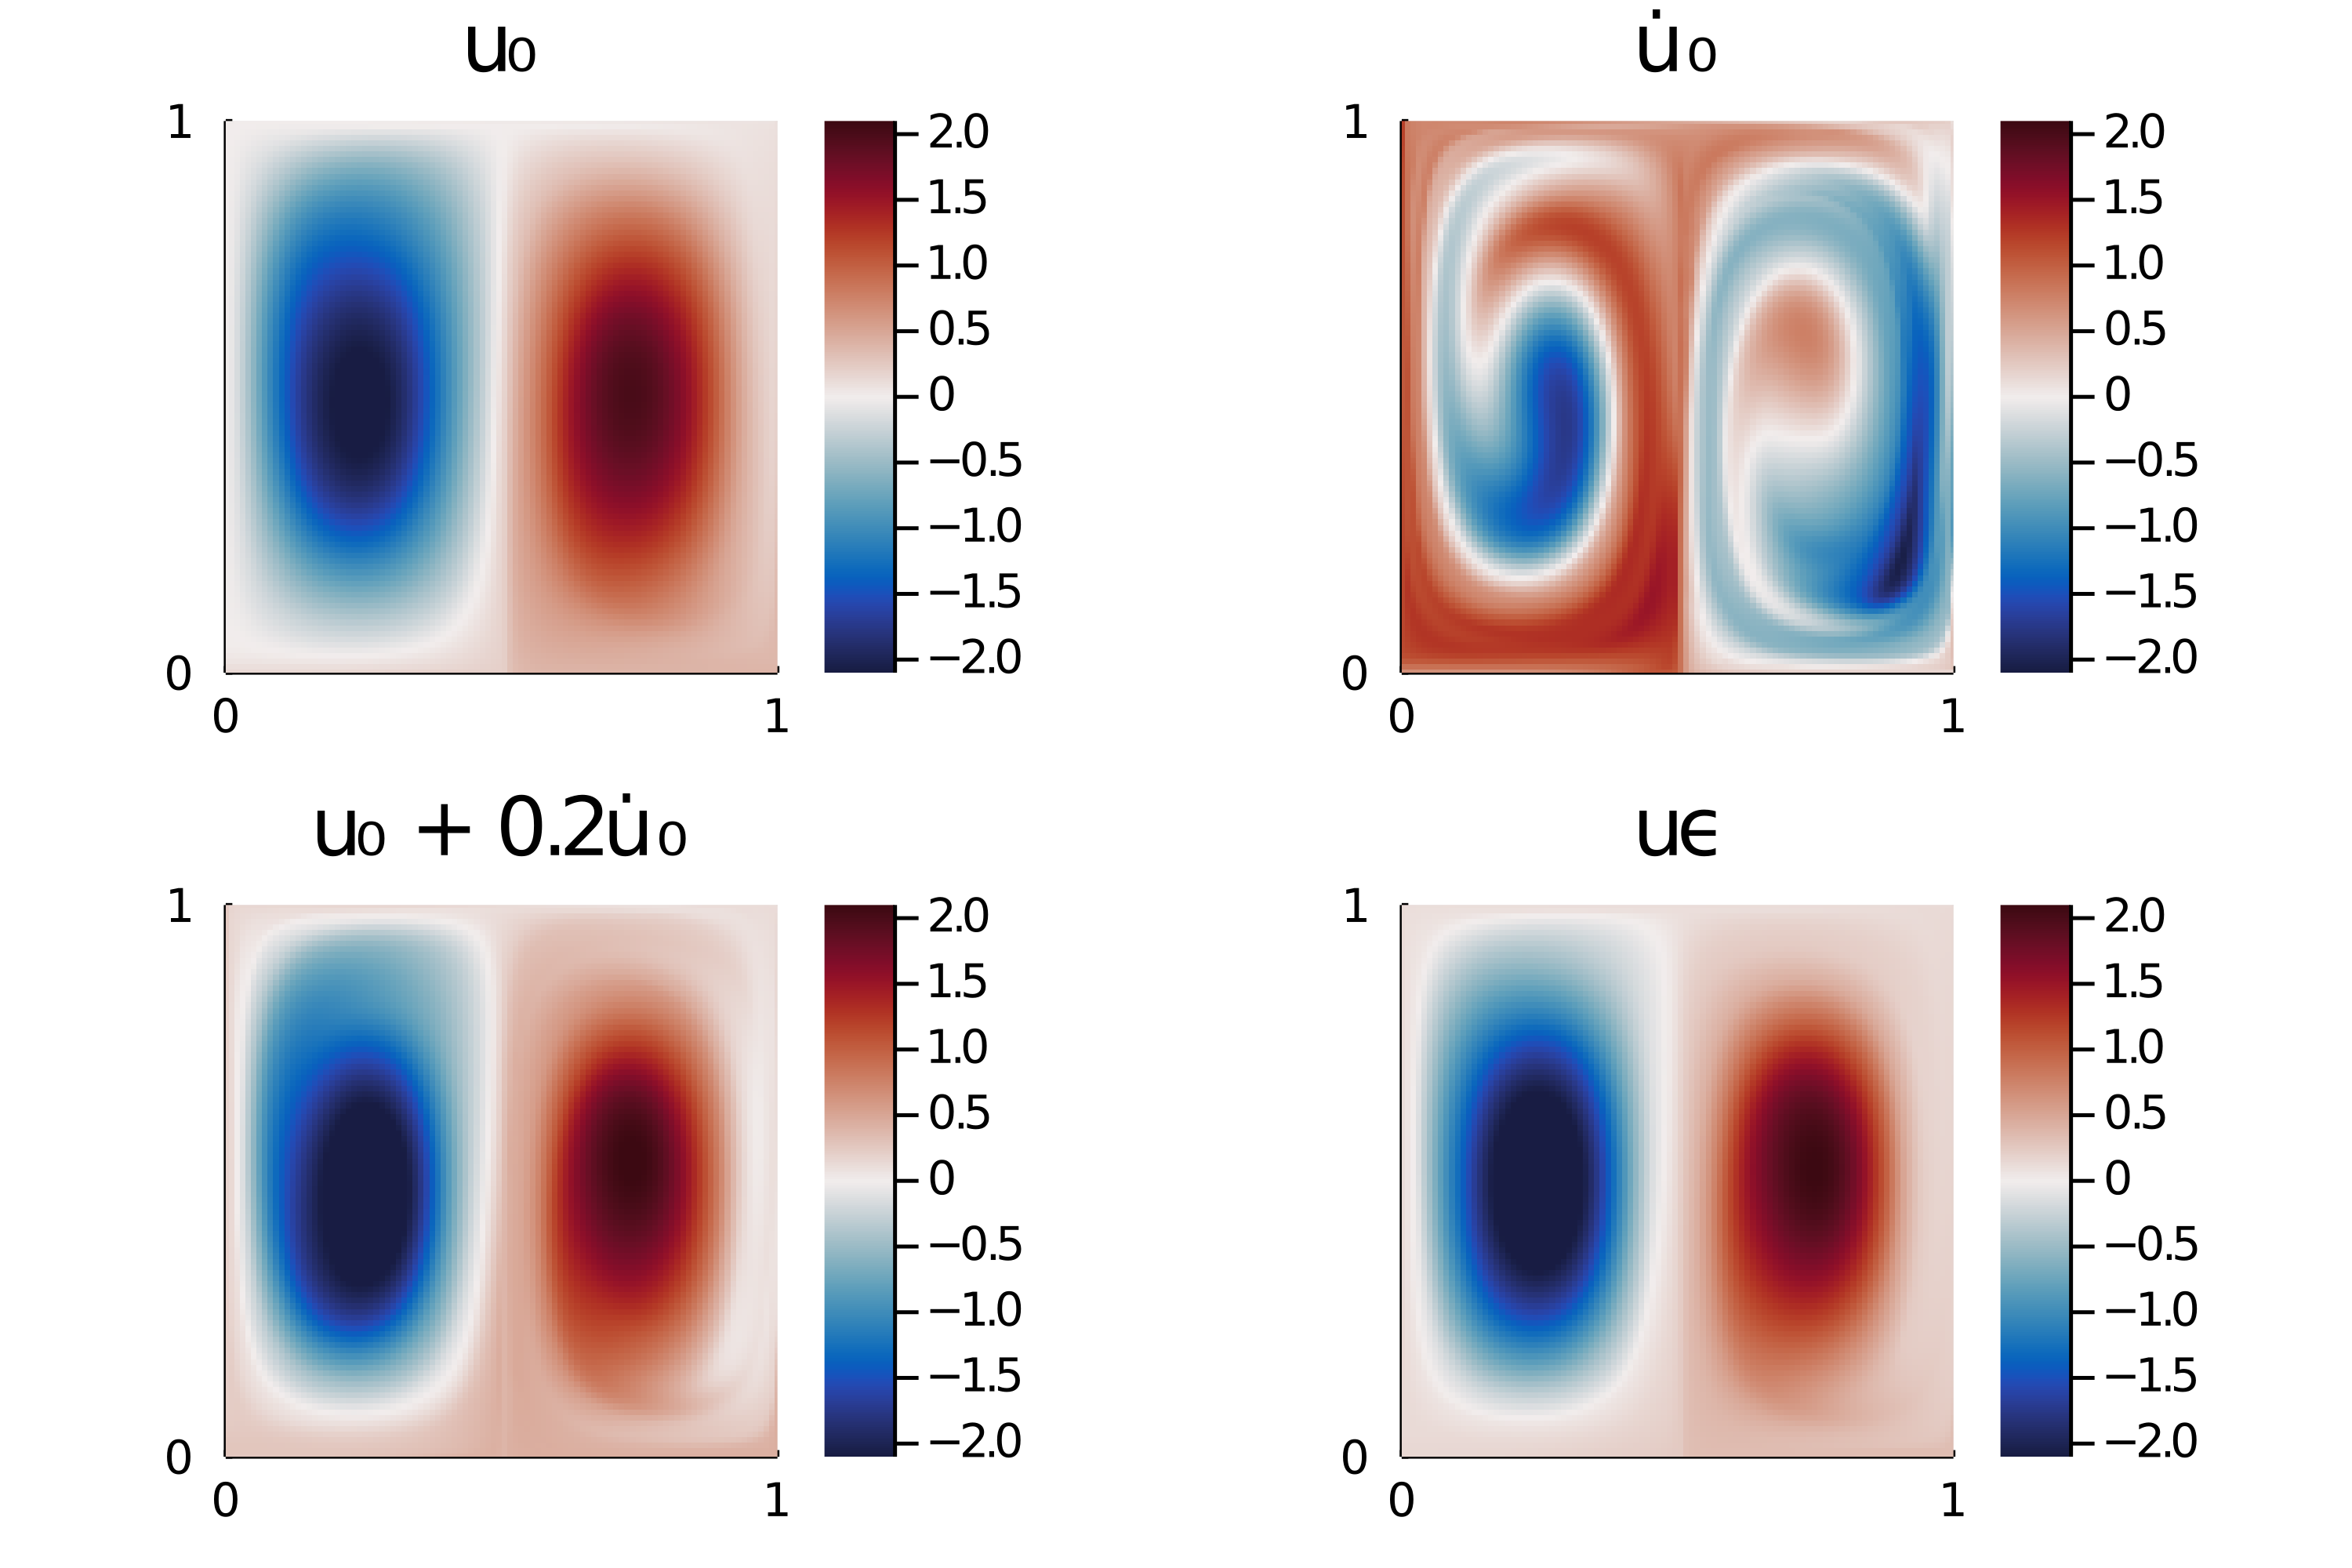

In [17]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmin =     -2.1
cmax =     2.1
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,           grid_resolution, grid_resolution, title="u₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, title="u̇ ₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, title="u₀ + $(ϵ)u̇ ₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, title="uϵ",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)